In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib

COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
import cv2
import imageio

import multiprocessing
from joblib import Parallel, delayed
from tqdm import trange
from tqdm import tqdm

import time
from sys import getsizeof
from IPython.display import clear_output

# lung division

# Import model

## Resnet 18

In [2]:

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNet18(nn.Module):

    def __init__(self, in_channel, n_classes):
        super().__init__()

        self.base_model = models.resnet18(pretrained=False)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(in_channel, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(in_channel=3, n_classes=2)
model = model.to(device)
print(device)

cuda


## Resnet 50

In [2]:
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetWithResnet50Encoder(n_classes=2)
model = model.to(device)
print(device)

cuda


# Dataloader

In [3]:
masks = os.listdir('dataset/ml')
train_masks = masks[:630]
test_masks = masks[630:]

In [4]:
len(masks)

704

In [5]:
630/704

0.8948863636363636

In [4]:
img_size = 512
aug_train = A.Compose([A.Resize(img_size, img_size, interpolation=1, p=1),
                A.ShiftScaleRotate(always_apply=False, p=0.1, shift_limit=(-0.059, 0.050), scale_limit=(-0.1, 0.07), rotate_limit=(-29, 29), interpolation=0, border_mode=1, value=(0, 0, 0), mask_value=None),
                A.Blur(always_apply=False, p=0.07, blur_limit=(3, 5)),
                A.GridDistortion(always_apply=False, p=0.07, num_steps=5, distort_limit=(-0.3, 0.3), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
                A.GridDropout(ratio= 0.01, p=0.1),
                A.GaussNoise(var_limit=(0, 0.001),p=0.1),
                A.Downscale(p=0.13, scale_min=0.4, scale_max=0.75, interpolation=0)

                ], p=1)
aug_test = A.Compose([A.Resize(img_size, img_size, interpolation=1, p=1)], p=1)  

In [6]:
         
class Dataloader(Dataset):
    def __init__(self, names, transforms):
        self.names = names
        self.transforms = transforms
    def __getitem__(self, idx):
        if self.names[idx].endswith('_mask.png'):
            image = cv2.imread(f'Lung Segmentation/CXR_png/{self.names[idx].replace("_mask.png", ".png")}')
        else:
            image = cv2.imread(f'Lung Segmentation/CXR_png/{self.names[idx]}')
        image = (image-image.min())/(image.max()-image.min())
        left = (cv2.imread(f'lungs/ml/{self.names[idx]}', cv2.IMREAD_GRAYSCALE))
        right = (cv2.imread(f'lungs/mr/{self.names[idx]}', cv2.IMREAD_GRAYSCALE))
        mask = np.concatenate((np.expand_dims(left, axis = 2),np.expand_dims(right, axis = 2)), axis=2)  
        if(mask.max() == 255):
            mask = (mask/255).astype('uint8')
        augs = self.transforms(image = image, mask = mask)
#         image = np.transpose(augs['image'], (2,0,1)).astype('float')
#         mask = np.transpose(augs['mask'], (2,0,1)).astype('float')
        return augs['image'], augs['mask'], self.names[idx][:-9]    
    def __len__(self):
        return len(self.names)
train_dl = DataLoader(Dataloader(train_masks, transforms = aug_train),
                      batch_size=4,
                     pin_memory= True,
                     shuffle = True,
                     num_workers = 16)
test_dl = DataLoader(Dataloader(test_masks,
                                transforms = aug_test),
                                batch_size=1,
                                num_workers=4,
                                pin_memory = True)

## Example

In [5]:
def img_with_masks(img, masks, alpha, return_colors = False):
    '''
    returns image with masks, 
    img - numpy array of image 
    masks - list of masks. Maximum 6 masks. only 0 and 1 allowed
    alpha - int transparency [0:1] 
    return_colors returns list of names of colors of each mask 
    '''
    colors = [
              [255,0,0],  
              [0,255,0],  
              [0,0,255],  
              [255,255,0],
              [0,255,255],
              [102,51,0]  
             ]
    color_names = [
        'Red',
        'greed',
        'BLue',
        'Yello',
        'Light',
        'Brown'  
    ]
    img = img - img.min()
    img = img /(img.max() - img.min())
    img *= 255
    img = img.astype(np.uint8)

    c = 0
    for mask in masks:
        mask = np.dstack((mask, mask, mask)) * np.array(colors[c])
        mask = mask.astype(np.uint8)
        img = cv2.addWeighted(mask,alpha, img, 1, 0.)
        c = c+1
    if return_colors ==False:
        return img
    else:
        return img, color_names[0:len(masks)]
    #**(1/len(masks))

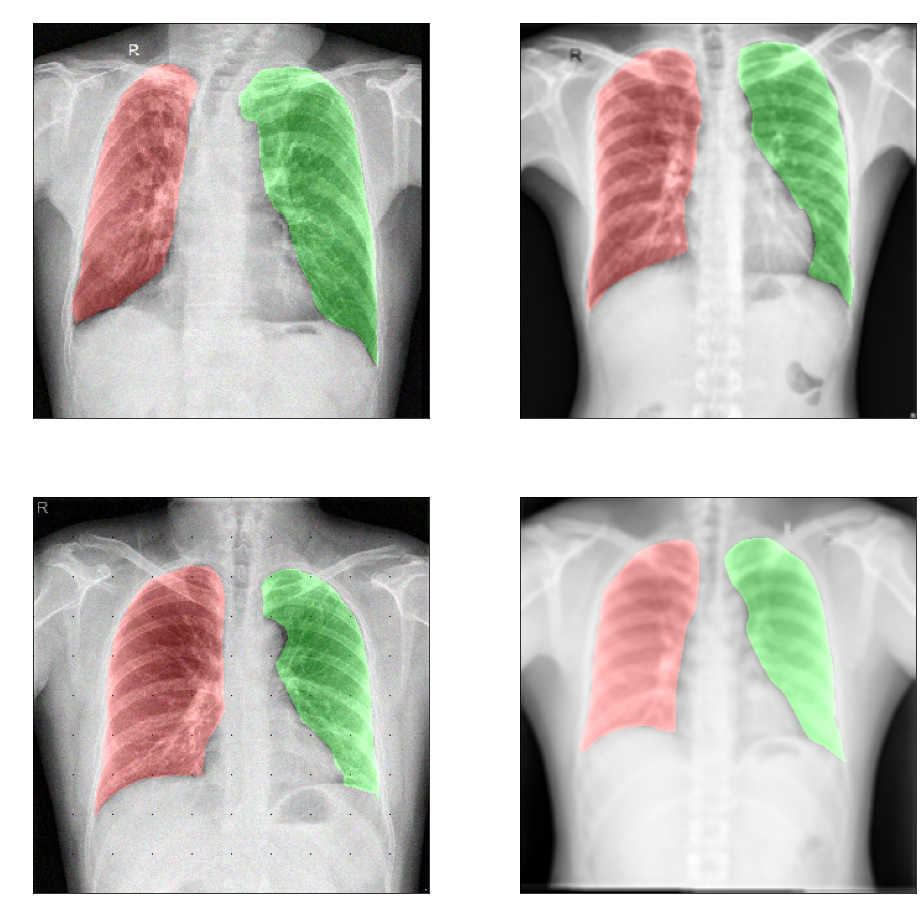

In [8]:
a, b, c = next(iter(train_dl))
plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(2,2,i+1)
    im = img_with_masks(a[i,:,:,:].cpu().detach().numpy(),[b[i,:,:,0], b[i,:,:,1]], 0.3)
    plt.title(c[i])
    plt.imshow(im)

# Train

In [9]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def iou(pred, target, thresh = 0.5):
    pred = (pred>=thresh)
    target = target > 0.5
    return ((pred&target).sum().item())/((pred|target).sum().item())
from bisect import bisect_right


In [10]:
bce_loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08)
#scheduller = AykhanLR(optimizer=optimizer, milestones=[0,5,7], gamma_list = [1e-4,1e-5, 1e-6])
scheduller = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,3, 5])

In [11]:
for epoch in tqdm(range(10), desc = 'Epoch'):
    last_metric = 0
    model.train();
    loss_history = []
    iou_history = []
    loss_test_history = []
    iou_test_history = []
    s = time.time()
    for idx, (images,masks, name) in tqdm(enumerate(train_dl), total =len(train_dl), leave=False, desc = 'Train batch'):
        optimizer.zero_grad()
        images= images.permute(0,3,1,2).float().to(device)
        masks = masks.permute(0,3,1,2).float().to(device)
        preds = nn.Sigmoid()(model(images))
        loss = dice_loss(preds, masks) + bce_loss(preds,masks)

        loss_history.append(loss.item())
        IOU = iou(preds, masks, 0.2)
        iou_history.append(IOU)
        loss.backward()
        optimizer.step()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    scheduller.step()
    print(f'Epoch: {epoch}, train loss: {np.mean(loss_history)}, train iou: {np.mean(iou_history)}, lr = {lr}, time: {time.time()-s}')


    model.eval()
    s = time.time()    
    for idx, (images,masks, names) in tqdm(enumerate(test_dl), total =len(test_dl), leave=False, desc = 'Test batch'):
        images= images.permute(0,3,1,2).float().to(device)
        masks = masks.permute(0,3,1,2).float().to(device)
        preds = nn.Sigmoid()(model(images))
        loss_test_history.append(dice_loss(preds, masks).item())
        iou_test_history.append(iou(preds, masks, 0.2))
    if (last_metric <np.mean(iou_test_history)):
        torch.save(model.state_dict(), f'lungs/weights/{epoch}.pth')
    last_metric = np.mean(iou_test_history)
    print(f'Epoch: {epoch}, test loss: {np.mean(loss_test_history)}, test iou: {np.mean(iou_test_history)}, time: {time.time()-s}')
    print('-----------------------------------------------')



Train batch: 100%|██████████| 158/158 [00:41<00:00,  7.00it/s]
                                                              

Epoch: 0, train loss: 0.5826982688394529, train iou: 0.5628623490424951, lr = 0.0001, time: 42.43197798728943



Epoch:  10%|█         | 1/10 [00:48<07:20, 48.93s/it]      

Epoch: 0, test loss: 0.08116265600674773, test iou: 0.8862686313565067, time: 6.496515512466431
-----------------------------------------------



Train batch: 100%|██████████| 158/158 [00:40<00:00,  7.82it/s]
                                                              

Epoch: 1, train loss: 0.11427473097662383, train iou: 0.8820370510003778, lr = 1e-05, time: 40.93069314956665



Epoch:  20%|██        | 2/10 [01:36<06:27, 48.49s/it]      

Epoch: 1, test loss: 0.06283444125358373, test iou: 0.8917463478267919, time: 6.5412681102752686
-----------------------------------------------



Train batch: 100%|██████████| 158/158 [00:40<00:00,  7.05it/s]
                                                              

Epoch: 2, train loss: 0.1076495964551651, train iou: 0.8876287105913991, lr = 1e-05, time: 40.93654251098633



Epoch:  30%|███       | 3/10 [02:24<05:37, 48.23s/it]      

Epoch: 2, test loss: 0.061938160902833286, test iou: 0.8975864514669097, time: 6.691364049911499
-----------------------------------------------



Train batch: 100%|██████████| 158/158 [00:41<00:00,  7.28it/s]
                                                              

Epoch: 3, train loss: 0.10519099985308285, train iou: 0.8901083161200004, lr = 1.0000000000000002e-06, time: 41.869911670684814



Epoch:  40%|████      | 4/10 [03:12<04:49, 48.31s/it]      

Epoch: 3, test loss: 0.060983516173819974, test iou: 0.8924672712318149, time: 6.614453315734863
-----------------------------------------------



Train batch: 100%|██████████| 158/158 [00:39<00:00,  7.71it/s]
                                                              

Epoch: 4, train loss: 0.10451854463619521, train iou: 0.8908034839619107, lr = 1.0000000000000002e-06, time: 40.30743193626404



Epoch:  50%|█████     | 5/10 [03:59<03:59, 47.87s/it]      

Epoch: 4, test loss: 0.060605441870754714, test iou: 0.8965701316039549, time: 6.535815954208374
-----------------------------------------------



Train batch: 100%|██████████| 158/158 [00:40<00:00,  7.72it/s]
                                                              

Epoch: 5, train loss: 0.10350005267352998, train iou: 0.8927085126759963, lr = 1.0000000000000002e-07, time: 40.97910284996033



Epoch:  60%|██████    | 6/10 [04:46<03:10, 47.75s/it]      

Epoch: 5, test loss: 0.06051923273360892, test iou: 0.8940733697344453, time: 6.484962224960327
-----------------------------------------------



Train batch: 100%|██████████| 158/158 [00:39<00:00,  7.70it/s]
                                                              

Epoch: 6, train loss: 0.10283603066507774, train iou: 0.8922592877005072, lr = 1.0000000000000002e-07, time: 40.169981241226196



Epoch:  70%|███████   | 7/10 [05:33<02:22, 47.42s/it]      

Epoch: 6, test loss: 0.06051740948468039, test iou: 0.8949450665258023, time: 6.473518133163452
-----------------------------------------------



Train batch: 100%|██████████| 158/158 [00:39<00:00,  7.72it/s]
                                                              

Epoch: 7, train loss: 0.10261284432645086, train iou: 0.8924113256966506, lr = 1.0000000000000002e-07, time: 39.99365282058716



Epoch:  80%|████████  | 8/10 [06:20<01:34, 47.17s/it]      

Epoch: 7, test loss: 0.060669318453906336, test iou: 0.8968550268147267, time: 6.583951950073242
-----------------------------------------------



Train batch: 100%|██████████| 158/158 [00:39<00:00,  7.59it/s]
                                                              

Epoch: 8, train loss: 0.10292985530782349, train iou: 0.8918909128310988, lr = 1.0000000000000002e-07, time: 40.228334188461304



Epoch:  90%|█████████ | 9/10 [07:06<00:47, 47.03s/it]      

Epoch: 8, test loss: 0.06060418445770055, test iou: 0.8971578948547922, time: 6.499180793762207
-----------------------------------------------



Train batch: 100%|██████████| 158/158 [00:39<00:00,  7.74it/s]
                                                              

Epoch: 9, train loss: 0.10279639286896851, train iou: 0.8923942326206677, lr = 1.0000000000000002e-07, time: 40.46684789657593



Epoch: 100%|██████████| 10/10 [07:53<00:00, 47.02s/it]     

Epoch: 9, test loss: 0.06037767700953026, test iou: 0.8959193617994023, time: 6.509774208068848
-----------------------------------------------


# Inference

In [6]:
model.load_state_dict(torch.load('experiments/resnet50/model_checkpoints/resnet50_epoch10.pth'))

<All keys matched successfully>

In [7]:
def inference(img_path, thresh = 0.2):
    model.eval();
    image = cv2.imread(f'{img_path}')
    image = (image-image.min())/(image.max()-image.min())
    augs = aug_test(image = image)
    image = augs['image'].transpose((2,0,1))
    im = augs['image']
    image = np.expand_dims(image, axis = 0)
    image = torch.tensor(image)

    mask = torch.nn.Sigmoid()(model(image.float().cuda()))
    mask = mask[0,:,:,:].cpu().detach().numpy()
    mask = (mask>thresh).astype('uint8')
    return im, mask

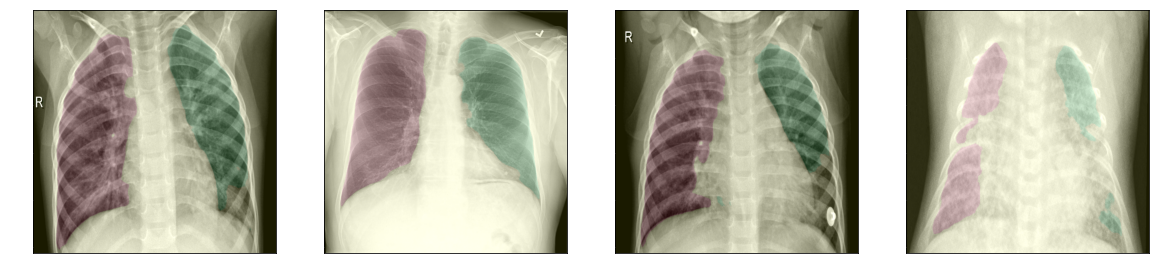

In [8]:
plt.figure(figsize=(20,40))

plt.subplot(1,4,1)
image, mask = inference('test/1.jpeg', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,2)
image, mask = inference('test/2.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,3)
image, mask = inference('test/3.jpeg', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,4)
image, mask = inference('test/4.jpeg', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

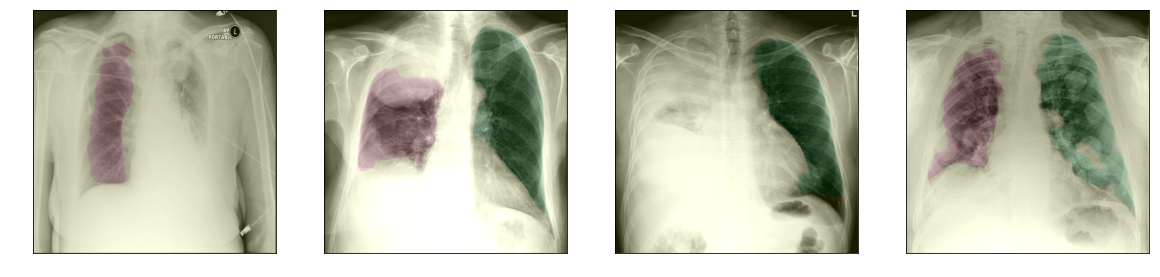

In [9]:
plt.figure(figsize=(20,40))

plt.subplot(1,4,1)
image, mask = inference('test/00013659_019.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,2)
image, mask = inference('test/mass.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,3)
image, mask = inference('test/progress_5.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

plt.subplot(1,4,4)
image, mask = inference('test/rcc_cannonball_mets.png', 0.2)
plt.imshow(img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

# Kek

In [15]:
from bisect import bisect_right as br
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from scipy.ndimage.measurements import label
from skimage.measure import regionprops
from scipy import ndimage

import matplotlib as mpl
from matplotlib.colors import ListedColormap
import cv2

In [ ]:
gradcam = np.load('4.npy')
# grmask = gradcam[0,0] - gradcam[0,0].min()
# grmask = grmask/grmask.max()
# grmask = cv2.resize(grmask, (320, 320))

In [ ]:
gradcam.shape

(1, 1, 480, 480)

In [ ]:
gradcam = cv2.cvtColor(gradcam, cv2.COLOR_BGR2GRAY)
gradcam = gradcam <=gradcam.min()
gradcam = gradcam.astype('uint8')
gradcam = cv2.resize(gradcam, (320, 320))

error: ignored

In [ ]:
image, mask = inference('/content/4.jfif', 0.2)
plt.figure(figsize=(6,6))
plt.imshow(img_with_masks(image, [mask[0], mask[1], gradcam[:,:]], 0.2))
#plt.plot(gradcam_points(gradcam)[1]*320, gradcam_points(gradcam)[0]*320,'r+', markersize=34)

In [ ]:
def pneumothorax(lungs, gradcam):
    blyat = {
        False:'right',
        True:'left'
    }
    symp = {
        False: "local",
        True: 'global'
    }    
    gradcam = cv2.cvtColor(gradcam, cv2.COLOR_BGR2GRAY)
    gradcam = gradcam <=gradcam.min()
    gradcam = gradcam.astype('uint8')
    gradcam = cv2.resize(gradcam, (320,320))
    position = (gradcam&lungs[1]).sum() >(gradcam&lungs[0]).sum()
    lung = blyat[position]
    area = gradcam.sum()/lungs[int(position)].sum()
    degree = symp[area>0.3]
    return(lung, degree)
    # 0 -right
    # 1 - left

In [ ]:
pneumothorax(mask,gradcam)

('right', 'global')

In [ ]:
def gradcam_points(gradcam):
    heatmap = gradcam.squeeze()
    thresh = 0.9
    bw = heatmap.copy()
    bw[bw < thresh] = 0
    img_cc, nb_cc = label(bw)
    cc = regionprops(img_cc)
    face_location = np.array([c.centroid for c in cc])
    face_location[0][0] = face_location[0][0]/gradcam.shape[2]
    face_location[0][1] = face_location[0][1]/gradcam.shape[3]
    return face_location[0]


In [ ]:
def get_final_mask(mask):
    final = cv2.connectedComponents(mask)[1]
    uni = np.unique(final,return_counts=True)
    indexes = [x for _,x in sorted(zip(uni[1],uni[0]))]
    indexes.pop(indexes.index(0))    
    final[final!=indexes[-1]] = 0
    final[final==indexes[-1]] = 1
    return final
def get_extremes(mask):
    for i in range(img_size):
        if mask[i,:].sum()>0:
            y1 = i
            break
    for i in range(1, img_size):
        if mask[-i,:].sum()>0:
            y2 = img_size - i
            break
    for i in range(img_size):
        if mask[:,i].sum()>0:
            x1 = i
            break
    for i in range(1, img_size):
        if mask[:,-i].sum()>0:
            x2 =img_size- i
            break
    return x1, x2+1, y1, y2+1
def get_position(mask, point):
    suka = {
    0 : 'upper',
    1 : 'middle',
    2 : 'lower',
    }
    blyat = {
        False:'right',
        True:'left'
    }
    shshs = {
        0:'prikornevaya',
        1: 'centralnaya',
        2:'periferichescaya'
    }
    
    left = get_final_mask(mask[0])
    right = get_final_mask(mask[1])
    lx1, lx2, ly1, ly2 = get_extremes(left)
    rx1, rx2, ry1, ry2 = get_extremes(right)
    up = min([ly1,ly2,ry1,ry2])
    down =max([ly1,ly2,ry1,ry2])
    bounds = [(up+((down-up)*0.25))/(img_size), (up+((down-up)*0.60))/(img_size)]

    position_vertical = suka[br(bounds, point[0])]
    lung = point[1]>(lx2+rx1)/(2*img_size)
    position_horizontal = blyat[lung]
    if lung:
        # huynya_bounds = [(rx1+rx2)/(3*img_size), (2*(rx1+rx2))/(3*img_size)]
        huynya_bounds = [(rx1+(rx2-rx1)*0.33)/(img_size), (rx1+(rx2-rx1)*0.66)/(img_size)]

    else:
        huynya_bounds = [(lx1+(lx2-lx1)*0.33)/(img_size), (lx1+(lx2-lx1)*0.66)/(img_size)]
    huynya = shshs[br (huynya_bounds, point[1])]    
    return position_vertical, position_horizontal, huynya

In [ ]:
get_position(mask,gradcam_points(gradcam))

('lower', 'left', 'centralnaya')

# Pytorch Lightning

## pip

In [ ]:
import collections
from datetime import datetime, timedelta
import os
import requests
import threading

_VersionConfig = collections.namedtuple('_VersionConfig', 'wheels,server')
VERSION = "torch_xla==nightly"  #@param ["xrt==1.15.0", "torch_xla==nightly"]
CONFIG = {
    'xrt==1.15.0': _VersionConfig('1.15', '1.15.0'),
    'torch_xla==nightly': _VersionConfig('nightly', 'XRT-dev{}'.format(
        (datetime.today() - timedelta(1)).strftime('%Y%m%d'))),
}[VERSION]
DIST_BUCKET = 'gs://tpu-pytorch/wheels'
TORCH_WHEEL = 'torch-{}-cp36-cp36m-linux_x86_64.whl'.format(CONFIG.wheels)
TORCH_XLA_WHEEL = 'torch_xla-{}-cp36-cp36m-linux_x86_64.whl'.format(CONFIG.wheels)
TORCHVISION_WHEEL = 'torchvision-{}-cp36-cp36m-linux_x86_64.whl'.format(CONFIG.wheels)

# Update TPU XRT version
def update_server_xrt():
  print('Updating server-side XRT to {} ...'.format(CONFIG.server))
  url = 'http://{TPU_ADDRESS}:8475/requestversion/{XRT_VERSION}'.format(
      TPU_ADDRESS=os.environ['COLAB_TPU_ADDR'].split(':')[0],
      XRT_VERSION=CONFIG.server,
  )
  print('Done updating server-side XRT: {}'.format(requests.post(url)))

update = threading.Thread(target=update_server_xrt)
update.start()

# Install Colab TPU compat PyTorch/TPU wheels and dependencies
#!pip uninstall -y torch torchvision
!gsutil cp "$DIST_BUCKET/$TORCH_WHEEL" .
!gsutil cp "$DIST_BUCKET/$TORCH_XLA_WHEEL" .
!gsutil cp "$DIST_BUCKET/$TORCHVISION_WHEEL" .
!pip install "$TORCH_WHEEL"
!pip install "$TORCH_XLA_WHEEL"
!pip install "$TORCHVISION_WHEEL"
!sudo apt-get install libomp5
update.join()

Updating server-side XRT to XRT-dev20200316 ...
Copying gs://tpu-pytorch/wheels/torch-nightly-cp36-cp36m-linux_x86_64.whl...
-
Operation completed over 1 objects/78.2 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp36-cp36m-linux_x86_64.whl...
\ [1 files][113.2 MiB/113.2 MiB]                                                
Operation completed over 1 objects/113.2 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.5 MiB/  2.5 MiB]                                                
Operation completed over 1 objects/2.5 MiB.                                      
Processing ./torch-nightly-cp36-cp36m-linux_x86_64.whl
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.5.0a0+bdd7dbf which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
Done updating server-side XRT: <Response [200]>
      Suc

In [ ]:
! pip install pytorch-lightning

     |████████████████████████████████| 6.0MB 3.4MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 829kB 33.1MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_lightning-0.7.1-cp36-none-any.whl size=145306 sha256=a55d0a2e887b7611c7bbfcae8f1a644b2cca04efaa09034ab736656c1ec396e7
  Stored in directory: /root/.cache/pip/wheels/dc/93/61/14094d2116ff739513dda993007501ae5701b78386b39d5912
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=dec93d1d460b44161030c9b421536c5e51dbf5b4c97aa14a4f505bae3a222afd
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built pytorch-lightning future
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


## Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib


COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
import cv2
import imageio

import multiprocessing
from joblib import Parallel, delayed
from tqdm import trange
from tqdm import tqdm_notebook
from colorama import Fore
from termcolor import colored


In [ ]:
def img_with_masks(img, masks, alpha, return_colors = False):
    '''
    returns image with masks, 
    img - numpy array of image 
    masks - list of masks. Maximum 6 masks. only 0 and 1 allowed
    alpha - int transparency [0:1] 
    return_colors returns list of names of colors of each mask 
    '''
    colors = [
              [255,0,0],  
              [0,255,0],  
              [0,0,255],  
              [255,255,0],
              [0,255,255],
              [102,51,0]  
             ]
    color_names = [
        'Red',
        'greed',
        'BLue',
        'Yello',
        'Light',
        'Brown'  
    ]
    img = img - img.min()
    img = img /(img.max() - img.min())
    img *= 255
    img = img.astype(np.uint8)

    c = 0
    for mask in masks:
        mask = np.dstack((mask, mask, mask)) * np.array(colors[c])
        mask = mask.astype(np.uint8)
        img = cv2.addWeighted(mask,alpha, img, 1, 0.)
        c = c+1
    if return_colors ==False:
        return img
    else:
        return img, color_names[0:len(masks)]
    #**(1/len(masks))

## Data Loader

In [ ]:
img_size = 224
aug_train = A.Compose([A.Resize(img_size, img_size, interpolation=1, p=1),
                A.ShiftScaleRotate(always_apply=False, p=0.1, shift_limit=(-0.059, 0.050), scale_limit=(-0.1, 0.07), rotate_limit=(-29, 29), interpolation=0, border_mode=1, value=(0, 0, 0), mask_value=None),
                A.Blur(always_apply=False, p=0.1, blur_limit=(3, 5)),
                A.GridDistortion(always_apply=False, p=0.1, num_steps=5, distort_limit=(-0.3, 0.3), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None)
                ], p=1)
aug_test = A.Compose([A.Resize(img_size, img_size, interpolation=1, p=1)], p=1)           
class Dataloader(Dataset):
    def __init__(self, names, transforms):
        self.names = names
        self.transforms = transforms
    def __getitem__(self, idx):
        image = cv2.imread(f'/content/images/images/{self.names[idx][:-9]}.png')
        image = (image-image.min())/(image.max()-image.min())
        left = (cv2.imread(f'/content/drive/My Drive/Colab/lungs/l/{self.names[idx]}', cv2.IMREAD_GRAYSCALE)).astype('uint8')
        right = (cv2.imread(f'/content/drive/My Drive/Colab/lungs/r/{self.names[idx]}', cv2.IMREAD_GRAYSCALE)).astype('uint8')
        mask = np.concatenate((np.expand_dims(left, axis = 2),np.expand_dims(right, axis = 2)), axis=2)  
        if(mask.max() == 255):
            mask = mask/255
        augs = self.transforms(image = image, mask = mask)
#         image = np.transpose(augs['image'], (2,0,1)).astype('float')
#         mask = np.transpose(augs['mask'], (2,0,1)).astype('float')
        return augs['image'], augs['mask'], self.names[idx][:-9]    
    def __len__(self):
        return len(self.names)

## Model

In [ ]:
import os

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import pytorch_lightning as pl

from pytorch_lightning import Trainer
from argparse import Namespace
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def iou(pred, target, thresh = 0.5):
    pred = (pred>=thresh)
    target = target > 0.5
    return ((pred&target).sum().item())/((pred|target).sum().item())
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),)
bce_loss = nn.BCELoss()

class Unet(pl.LightningModule):

    def __init__(self, in_channel, n_classes):
        super().__init__()

        self.base_model = models.resnet18(pretrained=False)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(in_channel, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

    def training_step(self, batch, batch_idx):
        x, y, z = batch
        x= x.permute(0,3,1,2)
        y = y.permute(0,3,1,2)
        y_hat = nn.Sigmoid()(self.forward(x))
        dice = dice_loss(y_hat, y) 
        bce = bce_loss(y_hat, y)
        loss = dice +bce
        return {'loss': loss, 'dice': dice, 'bce':bce}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

    def prepare_data(self):
        masks = os.listdir('/content/drive/My Drive/Colab/lungs/l')
        self.train_masks = masks[:500]
        self.test_masks = masks[500:]
    def train_dataloader(self):
        loader = DataLoader(Dataloader(self.train_masks, aug_train),
                      batch_size=32,
                     pin_memory= True,
                     num_workers = 1)
        return loader

    def val_dataloader(self):
        loader = DataLoader(Dataloader(test_masks, aug_test), batch_size=16, pin_memory = False)
        return loader


## Train

In [ ]:
model = Unet(in_channel=3, n_classes=2)
#num_tpu_cores
trainer = Trainer(num_tpu_cores=1, max_epochs=10, precision=16)
trainer.fit(model) 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2836: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
